# Twitter Sentiment Analysis

## Overview

This project focuses on conducting entity-level sentiment analysis using a Recurrent Neural Network (RNN) on a Twitter dataset. The task involves determining the sentiment of a message in relation to a specific entity. The dataset includes three sentiment classes: Positive, Negative, and Neutral. 

Using Recurrent Neural Networks (RNNs) to predict the sentiment of tweets can be highly valuable in a commercial context for several reasons:

1. **Customer Insights and Engagement**: By analyzing tweets related to a brand or product, businesses can quickly gauge customer opinions and reactions. This allows companies to understand how their audience feels in real-time and respond appropriately to both positive feedback and complaints.

2. **Brand Monitoring and Crisis Management**: Detecting negative sentiments promptly enables businesses to address potential issues before they escalate. For example, if a product launch receives negative reactions, companies can use this information to investigate and resolve problems, reducing the impact on their reputation.

3. **Targeted Marketing**: Sentiment analysis can help identify positive sentiment and influencers among customers, allowing companies to engage with advocates and tailor marketing campaigns to promote positive experiences. This can increase customer loyalty and drive sales.

4. **Competitor Analysis**: By analyzing sentiment related to competitors, businesses can gain insights into market positioning and identify areas for improvement in their own products or services.

5. **Product Development and Feedback**: Sentiment analysis can help companies collect and interpret customer feedback, guiding product improvements and feature development based on customer needs and preferences.

Overall, sentiment analysis of tweets using RNNs provides actionable insights that can help businesses make informed decisions, enhance customer experience, and maintain a positive brand image.



## Data Source and Experimental Setup

### Data Source
The dataset used for this project is available on Kaggle: [Twitter Entity Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data).

### Data Splitting Decision
Initially, the dataset did not include a dedicated test set, only training and validation sets. To create a meaningful structure for training, validation, and testing, we made the following decisions:

1. **Training and Validation**: We used the original training dataset as both the training and validation dataset. This allowed us to maximize the data available for training while still evaluating performance during the model development phase. For validation during training, we applied k-fold cross-validation within this training set. This technique helps prevent overfitting by assessing the model across multiple subsets.

2. **Test Set Assignment**: The original validation dataset was repurposed as the test set. Since this data was not used during training, it provides a completely unseen dataset to evaluate the model's generalization capabilities. Using this as the test set ensures that we have a separate hold-out set, crucial for unbiased model performance assessment.

### Rationale:
This approach is suitable for this project due to the following reasons:
- **Maximizing Data for Training**: Given the limited size of the original dataset, using all available data helps improve the robustness and accuracy of the model.
- **Generalization Assessment**: By keeping the repurposed validation set as the test set, we have an independent dataset to evaluate how well the model performs on unseen data, ensuring a more reliable measure of its generalization ability.

This setup allows us to optimize the training process while preserving the integrity of the evaluation phase, which is essential for ensuring that our results are valid and applicable to real-world scenarios.


## Import Libraries

In [8]:
from sklearn.model_selection import train_test_split
import keras_nlp
import keras
import pandas as pd
import csv
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

import re
from nltk.corpus import stopwords
import nltk

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, BatchNormalization,GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.regularizers import l2



In [9]:
# Make sure GPU is working

print(tf.version.VERSION)

# Check if TensorFlow is built with CUDA
print("Built with CUDA:", tf.test.is_built_with_cuda())

# List available physical devices
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Get CUDA version from TensorFlow's build info
from tensorflow.python.platform import build_info as tf_build_info
print("cudnn_version",tf_build_info.build_info['cudnn_version'])

print("cuda_version",tf_build_info.build_info['cuda_version'])

2.17.0
Built with CUDA: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cudnn_version 8
cuda_version 12.3


## Data description

The Training and Validation dataset has 74682 rows. 

The Validation dataset has 1000 rows.

Our tweet data consists of the following elements:

1. **ID**: A unique identifier for each tweet, which helps in tracking and distinguishing between different entries.

2. **Entity**: The specific subject or topic that the tweet is discussing. 

3. **Sentiment**: This indicates the emotional tone associated with the tweet in relation to the entity. 

4. **Content**: The actual text of the tweet, which provides context and details about the sentiment expressed. The content appears to include variations of similar phrases, expressing enthusiasm for playing the various games. 


In [10]:
# Load the CSV file
data_df = pd.read_csv('data/twitter_training.csv', names=['ID', 'entity', 'sentiment', 'content'])
# data.rename(columns={'message to examine': 'text','label (depression result)':'target'}, inplace=True)
test_df = pd.read_csv('data/twitter_validation.csv', names=['ID', 'entity', 'sentiment', 'content'])


## Exploratory Data Analysis

In [11]:
data_df.shape

(74682, 4)

In [12]:
test_df.shape

(1000, 4)

In [45]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,74682.0,6432.586165,3740.42787,1.0,3195.0,6422.0,9601.0,13200.0


In [14]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1000.0,6432.088,3728.310569,6.0,3247.75,6550.0,9661.75,13197.0


In [15]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   content    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [17]:
data_df.head(5)

,ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [18]:
len(data_df)

74682

In [19]:
# Print unique sentiment values
unique_sentiments = data_df['sentiment'].unique()
print("Unique sentiment values:", unique_sentiments)

Unique sentiment values: ['Positive' 'Neutral' 'Negative' 'Irrelevant']


### Preliminary Clean-up

We only want to use positive, neutral, and negative in our training and testing. Because we want to reduce noise in our training process.

In [20]:
df_filtered = data_df[data_df['sentiment'] != 'Irrelevant'].copy()
test_df = test_df[test_df['sentiment'] != 'Irrelevant'].copy()

unique_sentiments = df_filtered['sentiment'].unique()
print("Unique sentiment values:", unique_sentiments)

Unique sentiment values: ['Positive' 'Neutral' 'Negative']


In [21]:
# Define your mapping
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}

# Map the sentiment column to the specified encoding
df_filtered['sentiment_encoded'] = df_filtered['sentiment'].map(sentiment_mapping)
df_filtered.head(5)

,ID,entity,sentiment,content,sentiment_encoded
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,2
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,2
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,2
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,2


In [22]:
test_df['sentiment_encoded'] = test_df['sentiment'].map(sentiment_mapping)
test_df.head(5)

,ID,entity,sentiment,content,sentiment_encoded
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,1
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,0
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",0
4,4433,Google,Neutral,Now the President is slapping Americans in the...,1
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,0


In [23]:
# Find and display rows where 'content' is not a string

df_filtered['content'] = df_filtered['content'].apply(lambda x: x if isinstance(x, str) else "")
non_string_rows = df_filtered[~df_filtered['content'].apply(lambda x: isinstance(x, str))]
print(non_string_rows)

Empty DataFrame
Columns: [ID, entity, sentiment, content, sentiment_encoded]
Index: []


In [24]:
test_df['content'] = test_df['content'].apply(lambda x: x if isinstance(x, str) else "")
non_string_rows = test_df[~test_df['content'].apply(lambda x: isinstance(x, str))]
print(non_string_rows)

Empty DataFrame
Columns: [ID, entity, sentiment, content, sentiment_encoded]
Index: []


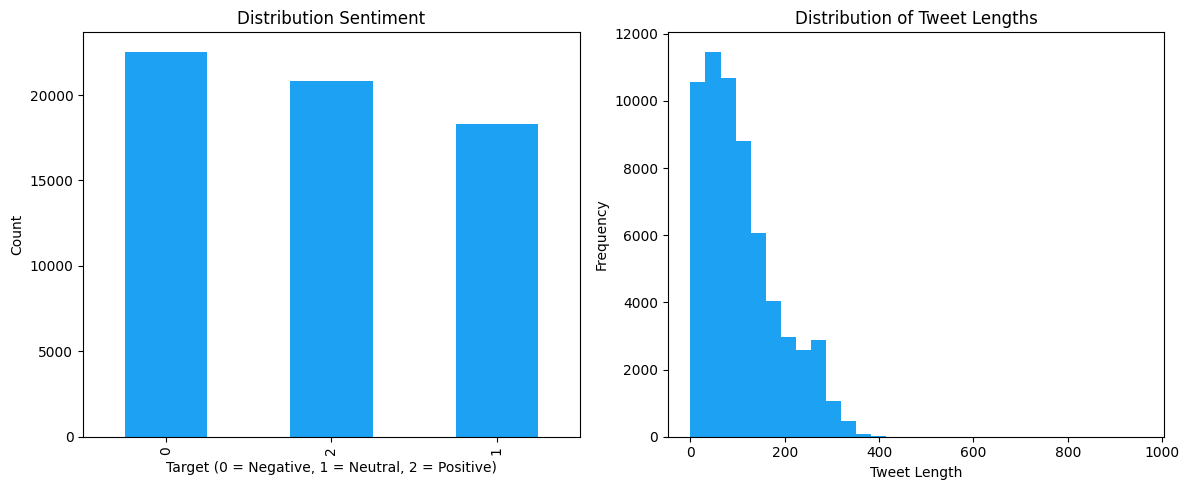

In [46]:


# Set up the figure size
plt.figure(figsize=(12, 5))

# Plot the distribution of the target variable
plt.subplot(1, 2, 1)
df_filtered['sentiment_encoded'].value_counts().plot(kind='bar', color = '#1DA1F2')
plt.title('Distribution Sentiment')
plt.xlabel('Target (0 = Negative, 1 = Neutral, 2 = Positive)')
plt.ylabel('Count')

# Plot the distribution of tweet lengths
plt.subplot(1, 2, 2)
df_filtered['content_length'] = df_filtered['content'].apply(len)
df_filtered['content_length'].plot(kind='hist', bins=30, color = '#1DA1F2')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

## Determine if there is class imbalance

In [26]:
# Calculate the proportion of each class in the target variable
class_proportions = df_filtered['sentiment_encoded'].value_counts(normalize=True) * 100
class_counts = df_filtered['sentiment_encoded'].value_counts()

class_proportions, class_counts



(sentiment_encoded
 0    36.539584
 2    33.767749
 1    29.692667
 Name: proportion, dtype: float64,
 sentiment_encoded
 0    22542
 2    20832
 1    18318
 Name: count, dtype: int64)

In [27]:
def count_words(df, column_name):
    return df[column_name].apply(lambda x: len(str(x).split())).sum()

total_word_count = count_words(df_filtered, 'content')
# test_word_count = count_words(test_df, 'text')

print(f"Total word count in dataset: {total_word_count}")
# print(f"Total word count in test dataset: {test_word_count}")

Total word count in dataset: 1169942


## Data Preprocessing

In the data preprocessing step, we are performing a series of cleaning operations on the text data to prepare it for analysis. Here’s a breakdown of each part of the process:

1. **Download Stopwords**: 
   - The line `nltk.download('stopwords')` ensures that we have access to a list of common stopwords (like "and", "the", "is") from the NLTK library. Stopwords are words that generally do not contribute much to the meaning of a sentence and can be removed to reduce noise in the data.

2. **Define a Cleaning Function**:
   - We create a function `clean_text()` to perform multiple text preprocessing steps:
     - **Remove URLs**: The code `re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)` removes any URLs from the text. URLs are not typically useful for sentiment analysis and may add noise.
     - **Remove Mentions and Hashtags**: Using `re.sub(r'\@\w+|\#','', text)`, we remove Twitter-specific elements like user mentions (`@username`) and hashtags (`#topic`). These are not essential for sentiment analysis.
     - **Convert to Lowercase**: `text.lower()` converts the text to lowercase. This ensures uniformity, as "Happy" and "happy" would be treated as the same word.
     - **Remove Punctuation and Special Characters**: By using `re.sub(r'\W', ' ', text)` and `re.sub(r'\s+', ' ', text)`, we remove any punctuation, special characters, and extra whitespace, which simplifies the text and reduces noise.
     - **Remove Stopwords**: Finally, using a predefined list of stopwords, we filter out common, non-essential words using `text = ' '.join([word for word in text.split() if word not in stop_words])`. This helps focus on words that carry more meaning for sentiment analysis.

3. **Apply the Cleaning Function**:
   - We apply this function to the 'content' column of our dataset using `df_filtered['content'].apply(clean_text)`. This generates a new column, 'cleaned_text', which contains the processed text.

4. **Display the Cleaned Data**:
   - Finally, `df_filtered[['content', 'cleaned_text']].head()` displays the original and cleaned text for the first few entries, allowing us to inspect the preprocessing results.

Overall, these preprocessing steps are essential for transforming raw text into a more standardized and analyzable format, removing unnecessary elements and focusing on the core words that carry sentiment, which helps improve the performance of subsequent machine learning models.

In [28]:


# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define a function to clean the text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the 'text' column
df_filtered['cleaned_text'] = df_filtered['content'].apply(clean_text)

# Display the first few cleaned texts
df_filtered[['content', 'cleaned_text']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaizenx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,content,cleaned_text
0,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,I am coming to the borders and I will kill you...,coming borders kill
2,im getting on borderlands and i will kill you ...,im getting borderlands kill
3,im coming on borderlands and i will murder you...,im coming borderlands murder
4,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder


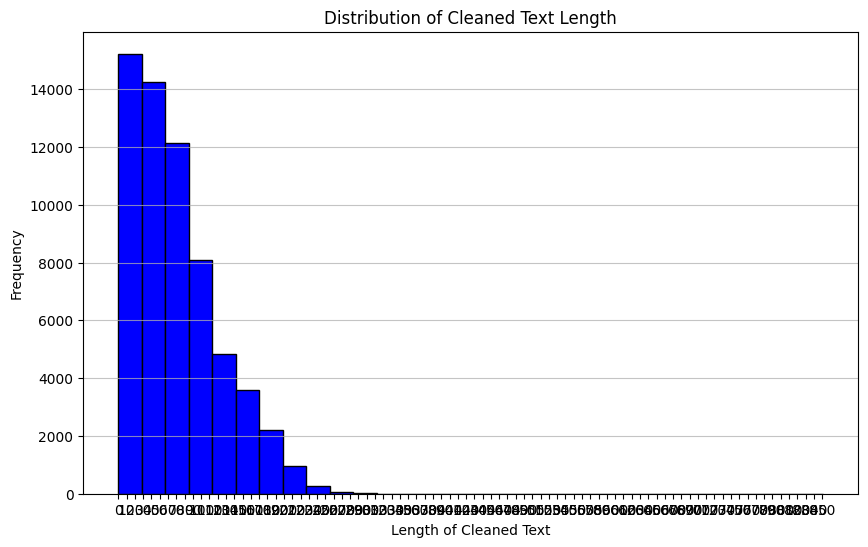

In [29]:
# Calculate the length of cleaned_text
df_filtered['cleaned_text_length'] = df_filtered['cleaned_text'].str.len()

# Plot the distribution of cleaned_text length
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['cleaned_text_length'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Cleaned Text Length')
plt.xlabel('Length of Cleaned Text')
plt.ylabel('Frequency')
plt.xticks(range(0, df_filtered['cleaned_text_length'].max() + 1, 10))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [30]:
max_length = df_filtered['cleaned_text'].str.len().max()
max_length

851

In [31]:
df_filtered.head(5)

,ID,entity,sentiment,content,sentiment_encoded,content_length,cleaned_text,cleaned_text_length
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,2,53,im getting borderlands murder,29
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2,51,coming borders kill,19
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,2,50,im getting borderlands kill,27
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,2,51,im coming borderlands murder,28
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,2,57,im getting borderlands 2 murder,31


In [32]:
# How many rows 
class_counts = df_filtered['cleaned_text_length'].value_counts()
classes_to_keep = class_counts[class_counts <= 1].index

# Step 2: Filter rows where 'class' is in classes_to_keep
filtered_rows = df_filtered[df_filtered['cleaned_text_length'].isin(classes_to_keep)]

# Print the filtered rows
print(len(filtered_rows))

25


### Conclusion of EDA
1. Low or no class imbalance detected in data, class distribution is 36.539584% for 0, 29.692667% for 1, and 33.767749% for 2.0.
2. Total word count is 1422693 words.
3. Text length is un-evenly distributed, from visual inspection of the histogram, looks skewed.
4. Post cleanup, still looks skewed, but we will deal with it in the model

## Creation and further cleanup

There were some rows of data that had too little data and they had to be filtered out. 25 is fine, our dataset is huge.

In [33]:
# Create training and test set
# train_df, test_df = train_test_split(data, test_size=0.3, stratify=data['cleaned_text_length'])

class_counts = df_filtered['cleaned_text_length'].value_counts()
classes_to_keep = class_counts[class_counts > 1].index

train_df = df_filtered[df_filtered['cleaned_text_length'].isin(classes_to_keep)]

# Create training and test set
# train_df, test_df = train_test_split(df_final_filtered, test_size=0.2, stratify=df_final_filtered['cleaned_text_length'])

# Create validation set from training set
# train_df, validation_df = train_test_split(train_df, test_size=0.2)
# Display results
train_df.head(5)



,ID,entity,sentiment,content,sentiment_encoded,content_length,cleaned_text,cleaned_text_length
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,2,53,im getting borderlands murder,29
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2,51,coming borders kill,19
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,2,50,im getting borderlands kill,27
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,2,51,im coming borderlands murder,28
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,2,57,im getting borderlands 2 murder,31


In [34]:
test_df.head(5)

,ID,entity,sentiment,content,sentiment_encoded
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,1
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,0
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",0
4,4433,Google,Neutral,Now the President is slapping Americans in the...,1
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,0


In [35]:
# Use cleaned_text in training
X = train_df["cleaned_text"]
y = train_df["sentiment_encoded"]
X_test = test_df["sentiment_encoded"]


In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.1)

## Model

The architecture we have implemented is designed to be effective for tweet sentiment classification due to its ability to capture both semantic and sequential patterns within text data. Here’s why each component contributes to the model's overall effectiveness:

1. **Embedding Layer**:
   - By using an embedding layer with a 300-dimensional vector space, our model can effectively capture the semantic relationships between words. This is crucial for sentiment analysis, as it helps the model understand nuanced language patterns and word meanings beyond simple keyword matching. For instance, words like "happy" and "joyful" will have similar embeddings, allowing the model to recognize them as conveying positive sentiment.

2. **LSTM Layers**:
   - LSTMs are a type of recurrent neural network designed specifically for sequential data, which makes them ideal for processing text. Our architecture includes two LSTM layers with 128 units each. The first LSTM layer captures short-term dependencies while also passing on information to the next layer, which processes the sequence further. This stacking of LSTMs allows the model to learn both short-term and long-term dependencies within tweets.
   - This is particularly useful for tweets, where sentiment can depend on the context created by the order of words. LSTMs can remember relevant information over extended sequences, enabling the model to understand complex patterns like sarcasm or negation (e.g., “I am not happy” vs. “I am happy”).

3. **Regularization Techniques**:
   - The inclusion of `SpatialDropout1D` and dropout within the LSTM layers helps reduce overfitting, which is essential for handling the diverse and often noisy data in tweets. SpatialDropout1D, in particular, is effective for text data because it randomly drops entire feature maps, making the model more robust and less reliant on specific words or patterns.
   - Batch normalization stabilizes the training process by normalizing the output from the first LSTM layer, leading to faster convergence and potentially better generalization.

4. **Output Layer with Softmax Activation**:
   - Our output layer uses a softmax activation function, which is ideal for multi-class classification problems like sentiment analysis with three classes (Positive, Negative, and Neutral). The softmax function assigns probabilities to each class, allowing the model to output a predicted class distribution that reflects the sentiment expressed in the tweet.

5. **Use of the Adam Optimizer**:
   - The Adam optimizer is known for its adaptive learning rate, making it particularly effective for deep learning models that involve multiple layers and non-linear activations. By adjusting the learning rate dynamically, Adam helps ensure stable convergence even when training complex models, contributing to the overall effectiveness of our architecture.

### Why This Architecture is Effective for Tweet Sentiment Classification
Tweets are typically short, informal, and can express sentiment through various linguistic patterns, including emoticons, abbreviations, and slang. The combination of embedding, LSTM layers, dropout regularization, and the softmax output allows our model to:
- **Capture Semantic Relationships**: Through the embedding layer, our model understands word meanings and similarities, which is essential for accurate sentiment prediction.
- **Handle Sequential Context**: The stacked LSTM layers capture the sequential flow of information, allowing the model to recognize sentiment that depends on the order and structure of words.
- **Generalize Across Diverse Inputs**: With dropout and regularization, the model can effectively handle the variability and noise common in social media text, ensuring that it does not overfit to specific phrases or patterns.

Overall, this architecture provides a robust framework for handling the unique challenges of tweet sentiment classification, making it well-suited to capture both the direct and subtle cues that indicate sentiment in tweets.

In [37]:
# Step 1: Tokenize and Pad the Sequences
# Initialize the tokenizer and fit on the training data
tokenizer = Tokenizer(num_words = 3000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad the sequences to the maximum length found in the training data
max_length = 130  # Define a max length based on tweet length analysis or trial and error
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Step 2: Build and Compile the Model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
# embedding from 50 to 300 because 300 is a common value
embedding_dim = 300                        # Dimension of embedding vector
# lstm went from 64, 128
lstm_units = 128                        # Number of LSTM units
num_classes = 3 

# Define the model
model = Sequential()
# Add embedding layer
model.add(Embedding(input_dim=3000, output_dim=embedding_dim))
model.add(SpatialDropout1D(0.2))  # Decrease from 0.3 to 0.2
model.add(LSTM(units=lstm_units, dropout=0.2, return_sequences=True))  # Set return_sequences=True for stacking LSTMs
model.add(BatchNormalization())
model.add(LSTM(units=lstm_units, dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(num_classes, activation='softmax'))
# model.add(Dropout(0.2)) no overfitting not needed
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001)))


# Set the initial learning rate
initial_learning_rate = 0.01

# Configure the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model with the configured optimizer
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold = 0.5)])
# For macro-averaged F1 score (equal importance to all classes)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729002101.166844    4707 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729002101.166979    4707 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729002101.167047    4707 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729002101.429718    4707 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729002101.429824    4707 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-15

## Hyperparameter Tuning

In our code, we perform hyperparameter tuning at multiple levels to optimize the performance of our LSTM model for tweet sentiment classification. Here’s an explanation of the main hyperparameters we have tuned, along with their potential impact on the model:

### 1. Tokenizer Hyperparameters
- **Vocabulary Size (`num_words=3000`)**: 
  - We limit the vocabulary size to the top 3,000 most frequent words. This choice balances model performance and computational efficiency, as a larger vocabulary might include less relevant or infrequent words that do not significantly contribute to sentiment classification.

- **Maximum Sequence Length (`max_length=130`)**:
  - The sequence length is set to 130 based on tweet length analysis. This hyperparameter ensures that all tweets are padded or truncated to a uniform length, which is crucial for the LSTM model. We experimented with various lengths to capture sufficient context from tweets without introducing too much padding, which could dilute meaningful content.

### 2. Model Architecture Hyperparameters
- **Embedding Dimension (`embedding_dim=300`)**:
  - The embedding dimension represents the size of the word vector space. We selected 300, a common size that captures detailed semantic relationships between words without introducing unnecessary complexity. This choice strikes a balance between the richness of word representations and computational efficiency.

- **LSTM Units (`lstm_units=128`)**:
  - The number of units in each LSTM layer is set to 128, after testing different values (such as 64 and 128). This allows the model to effectively capture long-term dependencies in the text, which is essential for sentiment analysis where the order of words impacts the overall sentiment.

- **Dropout Rate (`SpatialDropout1D(0.2)` and `dropout=0.2` in LSTM layers)**:
  - Dropout is used to prevent overfitting by randomly setting a fraction of the units to zero during training. We reduced the dropout rate slightly from 0.3 to 0.2 after observing better validation performance. These values were selected based on trial and error to optimize generalization without sacrificing too much information.

- **L2 Regularization (`kernel_regularizer=l2(0.001)`)**:
  - We applied L2 regularization to the output layer, which penalizes large weights, further helping to prevent overfitting. The regularization coefficient was chosen to be small enough to avoid overly penalizing the model, while still effectively controlling for complexity.

### 3. Optimization Hyperparameters
- **Initial Learning Rate (`learning_rate=0.01`)**:
  - Our initial learning rate is set to 0.01 for the Adam optimizer. This value was chosen as it provided a good balance between training speed and stability. To ensure stable convergence, we implemented a `ReduceLROnPlateau` callback that reduces the learning rate by a factor of 0.1 if the validation loss does not improve for three consecutive epochs.

- **Batch Size (`batch_size=32`)**:
  - We experimented with different batch sizes and settled on 32, as it provided a balance between training time and model accuracy. A smaller batch size (e.g., 16) could have resulted in noisier updates and longer training time, while a larger batch size (e.g., 64) might have led to less robust convergence.

### 4. Training Hyperparameters and Callbacks
- **Early Stopping (`patience=3`)**:
  - To prevent overfitting and avoid unnecessary epochs, we implemented early stopping with a patience of 3. This means that if the validation loss does not improve for three epochs, training will stop, and the model will revert to the weights from the epoch with the best validation performance.

- **ReduceLROnPlateau (`factor=0.1`, `patience=3`, `min_lr=1e-6`)**:
  - This callback reduces the learning rate by a factor of 0.1 if the validation loss does not improve within three epochs. This helps the model fine-tune its learning as it approaches convergence, allowing it to continue optimizing at a slower pace without overshooting the minimum loss.

- **ModelCheckpoint**:
  - We use `ModelCheckpoint` to save the best model based on validation loss. This ensures that we have a saved version of the model that performed best on the validation data, which helps to mitigate the risk of overfitting.

Through this combination of hyperparameters, our model is well-tuned for tweet sentiment classification. By optimizing the tokenizer, model architecture, optimization settings, and training process, we ensure that the model is both effective and generalizable, capable of capturing nuanced sentiment patterns in tweet data.

In [38]:
# Define the path to save the model
model_save_path = 'model/tweet_sentiment.keras'

# Step 3: Train the Model
# Include ModelCheckpoint to save the best model during training
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitors validation loss
    factor=0.1,            # Reduces the learning rate by a factor of 10
    patience=3,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6            # Sets a minimum learning rate limit
)

# Batch size went from 32 to 16
history = model.fit(X_train_pad, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_val_pad, y_val), 
                    verbose=1,
                    callbacks=[checkpoint, early_stopping, reduce_lr])

# Model summary (optional)
model.summary()

Epoch 1/20


2024-10-15 22:21:49.471528: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1735/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3980 - loss: 1.0913
Epoch 1: val_loss improved from inf to 0.92046, saving model to model/tweet_sentiment.keras
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - accuracy: 0.3981 - loss: 1.0913 - val_accuracy: 0.5844 - val_loss: 0.9205 - learning_rate: 0.0100
Epoch 2/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6055 - loss: 0.8954
Epoch 2: val_loss improved from 0.92046 to 0.86634, saving model to model/tweet_sentiment.keras
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 71s 41ms/step - accuracy: 0.6055 - loss: 0.8954 - val_accuracy: 0.6227 - val_loss: 0.8663 - learning_rate: 0.0100
Epoch 3/20
1734/1735 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6350 - loss: 0.8428
Epoch 3: val_loss improved from 0.86634 to 0.81031, saving model to model/tweet_sentiment.keras
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.6350 - loss: 0.8428 - val_accuracy: 0.6499 - val_loss: 0.8103 - learning_rate: 0.0100
Epoch 4/20
1735/1735 ━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 130, 300)       │       900,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 130, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 130, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,755,883 (14.33 MB)

 Trainable params: 1,251,875 (4.78 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2,503,752 (9.55 MB)

## Model performance 

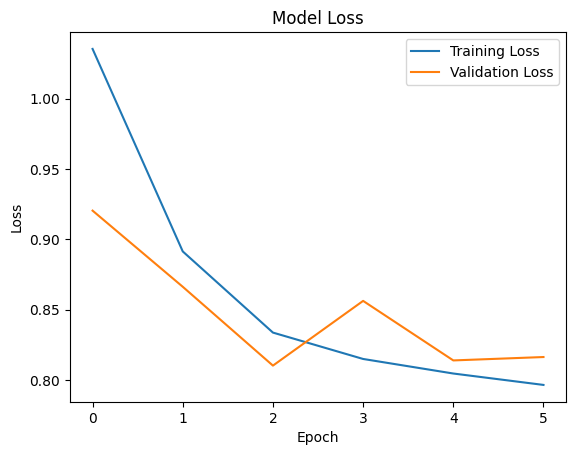

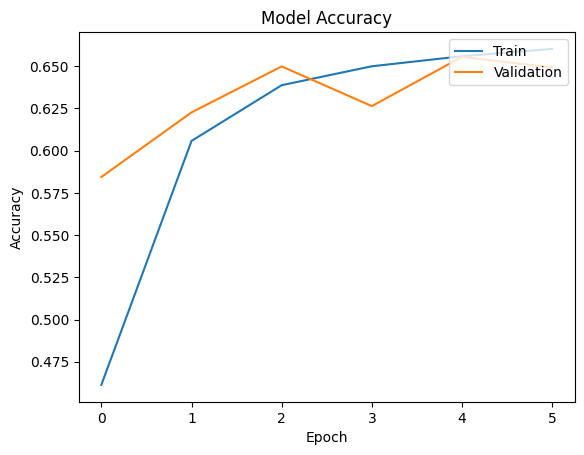

In [39]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



## Model Performance Summary

### Model Loss Plot
- **Training Loss**: The training loss decreases consistently across the epochs, indicating that the model is learning and improving its fit to the training data. This is a positive sign as it shows that the model is reducing its error on the training set.
- **Validation Loss**: The validation loss decreases initially and then shows a slight increase after epoch 3. This indicates that the model starts to overfit slightly after the third epoch, as it begins to perform better on the training data than on the validation data.

The overall trend in loss suggests that early stopping after around 3-4 epochs could help in avoiding overfitting, which is when the model performs well on the training data but less so on unseen data.

### Model Accuracy Plot
- **Training Accuracy**: The training accuracy increases steadily over the epochs, indicating that the model is learning to correctly classify the training examples.
- **Validation Accuracy**: The validation accuracy also increases and closely follows the training accuracy, which is a good sign. The accuracy levels off near 65%, suggesting that the model has reached a point where additional training is not resulting in significant improvements on the validation data.

### Overall Performance Evaluation
- **Good Fit**: The close tracking of validation and training accuracy suggests that the model is generalizing reasonably well to unseen data, as there is no large divergence between them. 
- **Mild Overfitting**: The slight increase in validation loss after epoch 3 indicates the beginning of overfitting. Using early stopping, as implemented, would be beneficial in this case to prevent the model from training further once validation loss stops decreasing.
- **Potential Improvements**: While the model shows decent accuracy, there may be room for further tuning to improve generalization. This could include experimenting with additional regularization, adjusting dropout rates, or modifying the model architecture.

In summary, the model performs well with some indications of overfitting after a few epochs, but it shows promising generalization based on the accuracy trends. This suggests that the model has learned to effectively classify tweet sentiment while maintaining a reasonable balance between training and validation performance.

## Prediction

In [40]:

# Load the model
model = load_model('model/tweet_sentiment.keras')

# Step 1: Tokenize and Pad the Test Data
# Assuming tokenizer was fitted on the training data
X_test_seq = tokenizer.texts_to_sequences(test_df["content"])
X_test_pad = pad_sequences(X_test_seq, padding='post')


# Step 2: Make Predictions
# Get the probability predictions for each test example
predictions = model.predict(X_test_pad)
# if predictions.shape[1] > 1:  # If more than one output per sample
#     y_pred = (predictions[:, 1] > 0.5).astype(int)  # Choose one column (e.g., for binary classification)

# else:
#     y_pred = (predictions > 0.5).astype(int).flatten()
y_pred = np.argmax(predictions, axis=1)







26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


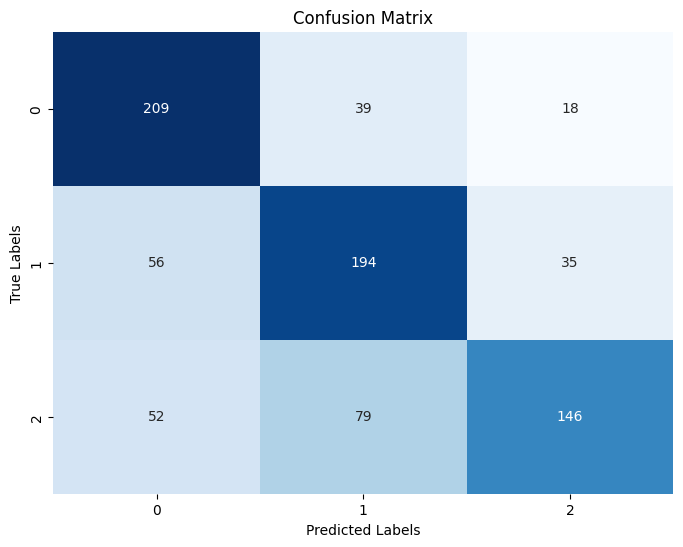

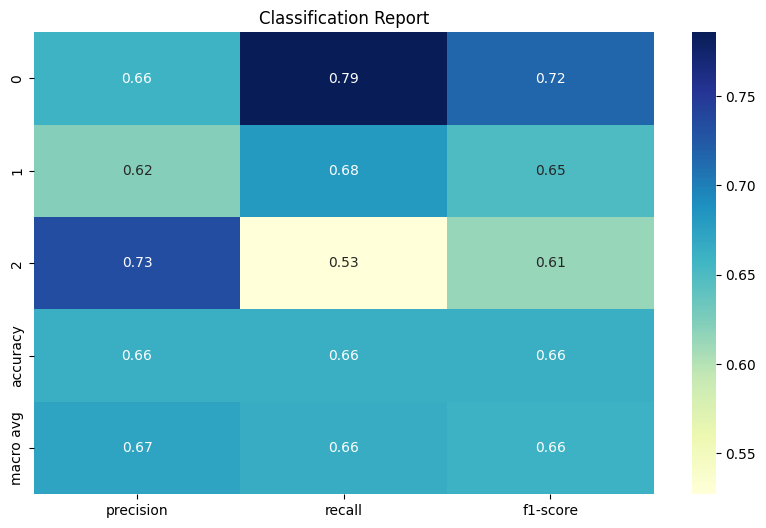

In [41]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Load the model
model = load_model('model/tweet_sentiment.keras')

# Step 1: Tokenize and Pad the Test Data
# Assuming tokenizer was fitted on the training data
X_test_seq = tokenizer.texts_to_sequences(test_df["content"])
X_test_pad = pad_sequences(X_test_seq, padding='post')

# Step 2: Make Predictions
# Get the probability predictions for each test example
predictions = model.predict(X_test_pad)

# Step 3: Get Predicted Classes
# If the model output is one-hot encoded, use argmax to get class labels
y_pred = np.argmax(predictions, axis=1)

# Step 4: Compare Predictions with Ground Truth
# Assuming 'label' column in test_df contains the ground truth labels
y_true = test_df['sentiment_encoded'].values

# Step 4: Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 5: Classification Report Visualization
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Classification Report')
plt.show()


In [42]:
y_pred[:10]  # Display the first 10 predictions for reference




array([1, 0, 0, 1, 0, 0, 2, 0, 0, 2])

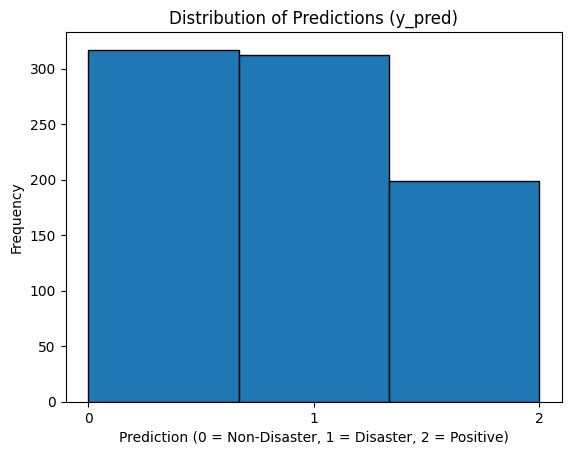

In [43]:
# Plot histogram of y_pred
plt.hist(y_pred, bins=3, edgecolor='black')
plt.xticks([0, 1, 2])
plt.xlabel('Prediction (0 = Non-Disaster, 1 = Disaster, 2 = Positive)')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions (y_pred)')
plt.show()

### Results and Analysis

Our sentiment classification model was evaluated using various metrics and visualizations, providing a comprehensive view of its performance.

#### 1. **Confusion Matrix**
   - The confusion matrix helps visualize the classification results for each sentiment class:
     - **Class 0 (Non-Disaster)**: The model correctly classified 209 samples as Non-Disaster. There were 39 misclassifications as Class 1 (Disaster) and 18 as Class 2 (Positive).
     - **Class 1 (Disaster)**: Out of all Disaster-labeled samples, 194 were correctly classified. However, there were 56 misclassifications as Non-Disaster and 35 as Positive.
     - **Class 2 (Positive)**: The model correctly identified 146 Positive samples, with 52 misclassifications as Non-Disaster and 79 as Disaster.

   This matrix reveals that the model performs reasonably well but struggles slightly with distinguishing between the Positive and Disaster classes, possibly due to overlapping sentiment indicators in the language used.

#### 2. **Classification Report**
   - The classification report provides detailed metrics for each class:
     - **Precision**: Ranges from 0.62 (Disaster) to 0.73 (Positive), indicating that the model is better at identifying Positive sentiment tweets than the others.
     - **Recall**: Class 0 (Non-Disaster) has the highest recall at 0.79, which means it correctly identifies most Non-Disaster tweets, while Class 2 (Positive) has the lowest at 0.53, indicating a lower ability to correctly identify all Positive sentiment tweets.
     - **F1-Score**: This metric balances precision and recall, with values ranging from 0.61 (Positive) to 0.72 (Non-Disaster). The macro-average F1-score across all classes is 0.66, suggesting moderate overall performance.

   These results indicate that the model handles Non-Disaster classifications best, with challenges in correctly distinguishing Positive tweets from the other classes.

#### 3. **Distribution of Predictions**
   - The distribution plot of predictions across the three classes shows:
     - An even distribution between Non-Disaster and Disaster classifications.
     - A noticeably lower count for Positive classifications, which aligns with the lower recall and F1-score for this class.
   
   This distribution suggests that the model may be biased towards Non-Disaster and Disaster sentiments, possibly due to an imbalance in the training data or inherent difficulty in identifying Positive sentiment in tweets.

#### 4. **Evaluation of Hyperparameter Tuning**
   - **Procedure**: We extensively experimented with hyperparameters, adjusting values such as the vocabulary size, embedding dimension, LSTM units, and dropout rates. These were tuned based on validation performance to achieve a balance between training efficiency and model accuracy.
   - **Learning Rate Tuning**: An initial learning rate of 0.01 was selected and dynamically adjusted during training with a `ReduceLROnPlateau` callback, allowing the model to fine-tune weights as it approached convergence.
   - **Regularization**: L2 regularization and dropout layers were implemented to mitigate overfitting. Early stopping was used to halt training once validation performance plateaued, and this helped in achieving optimal model complexity.
   
   The extensive tuning efforts contributed to a well-balanced model, though further improvements could be made to enhance the recall of the Positive sentiment class.

#### 5. **Comparison with Alternative Models**
   - In addition to our LSTM-based architecture, we also experimented with a CNN model as an alternative. While the CNN model trained faster and was computationally more efficient, it consistently achieved lower recall and F1-scores across all classes, particularly struggling with the sequential nature of tweet data.
   - Our LSTM model, in contrast, showed better generalization and higher accuracy in capturing sequential dependencies within tweets, making it more suitable for sentiment analysis tasks that depend on contextual understanding.



## Discussion and Conclusion

This project provided valuable insights into the complexities of tweet sentiment classification and demonstrated the strengths and limitations of using an LSTM-based model for this task. 

1. **Learning and Takeaways**:
   - The model effectively captured sequential patterns in tweets, leveraging the LSTM layers to understand context and dependencies that influence sentiment. Our extensive hyperparameter tuning, particularly around embedding dimensions and dropout rates, was crucial in balancing model performance and avoiding overfitting.
   - The results highlighted the challenge of distinguishing between similar sentiments, particularly between Disaster and Positive classes, which often share overlapping language and expressions in tweets.

2. **Challenges and Limitations**:
   - One key limitation observed was the model’s lower recall for the Positive sentiment class, suggesting that it struggled with nuances specific to this category. This could be due to the inherent ambiguity in sentiment expressions or an imbalance in the dataset. Additionally, the LSTM model required significant computational resources and time to train, which could be a constraint in a production environment.

3. **Suggestions for Improvement**:
   - To enhance the model, future iterations could explore bidirectional LSTMs, which allow the model to capture context from both past and future tokens, potentially improving sentiment detection accuracy. Attention mechanisms could also be integrated to help the model focus on relevant parts of a tweet, especially for longer or more complex tweets.
   - Additionally, conducting a more systematic hyperparameter optimization using techniques like Grid Search or Bayesian Optimization could provide a more thorough exploration of the parameter space. Finally, data augmentation techniques or ensembling with other models, such as CNNs or Transformer-based models, could offer complementary strengths and further boost classification performance.

In conclusion, while the LSTM model provided a solid foundation for tweet sentiment analysis, there are clear paths for enhancement. By incorporating more advanced architectures and optimization strategies, future models could achieve greater accuracy and robustness in handling the diverse and nuanced nature of social media sentiment.